# Problem Statement: 

Unplanned machine downtime poses significant financial and operational challenges in industrial settings. Conventional maintenance approaches may not be the most efficient means of tackling unforeseen machine downtime as they rely on scheduled preventative and reactive corrective maintenance methods. The goal of this project is to use machine learning to predict potential machine failures ahead of time, enabling companies to implement predictive maintenance strategies that minimize downtime, reduce operational costs and improve efficiency.

---

# Data

Maintenance datasets are often  difficut to access since most are not publicly available. Therefore, I chose to leverage the **AI4I 2020 Predictive Maintenance Dataset** from UC Irvine's Machine Learning Repository for this project. 

The Dataset is a synthetic yet realistic representation of sensor and operational data collected from CNC milling machines in an industrial setting. It was designed to simulate real-world production environments where predictive maintenance plays a critical role in minimizing equipment downtime. 

The dataset includes 10,000 instances with features such as:
- Air and process temperatures
- Rotational speed and torque
- Tool wear time
- Machine type (L, M, H)

The dataset also includes **binary labels** for different failure types:
`TWF`, `HDF`, `PWF`, `OSF`, `RNF`, and a combined `Machine failure` flag. Its richness makes it highly suitable for supervised machine learning tasks, allowing for both binary classification (failure vs. no failure) and multi-label classification (specific failure types). This dataset is especially valuable for demonstrating how data science can bridge the gap between technical performance metrics and operational decision-making in manufacturing and defense industries.

In [272]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 


In [273]:
# Load dataset
df = pd.read_csv("data/ai4i2020.csv")

df.columns = (
    df.columns
      .str.strip()                             
      .str.replace(' ', '_')                   
      .str.replace('[^A-Za-z0-9_]+', '', regex = True)     
      .str.lower() 
)

df.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,twf,hdf,pwf,osf,rnf
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [274]:
# Feature Engineering: (Adding failure and maintenance type)

# function to return failure type
def get_failure_type(row):
    for f in ['twf', 'hdf', 'pwf', 'osf', 'rnf']:
        if row[f]==1:
            return f
    return 'none'

df['failure_type'] = df.apply(get_failure_type, axis = 1)
# if there is a failure maintenance = corrective else it is preventive
df['maintenance_type'] = df['machine_failure'].apply(lambda x: 'corrective' if x==1 else 'preventive')
# transform column type from categorical to  
df = pd.get_dummies(df, columns = ['type'], drop_first = True)
 
df['has_failed'] = df['failure_type'].apply(lambda x: 0 if x == 'none' else 1)


df['type_L'] = df['type_L'].astype(int)
df['type_M'] = df['type_M'].astype(int)
df.columns = df.columns.str.lower()

df.head()



,udi,product_id,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,twf,hdf,pwf,osf,rnf,failure_type,maintenance_type,type_l,type_m,has_failed
0,1,M14860,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,none,preventive,0,1,0
1,2,L47181,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,none,preventive,1,0,0
2,3,L47182,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,none,preventive,1,0,0
3,4,L47183,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,none,preventive,1,0,0
4,5,L47184,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,none,preventive,1,0,0


---

# EDA

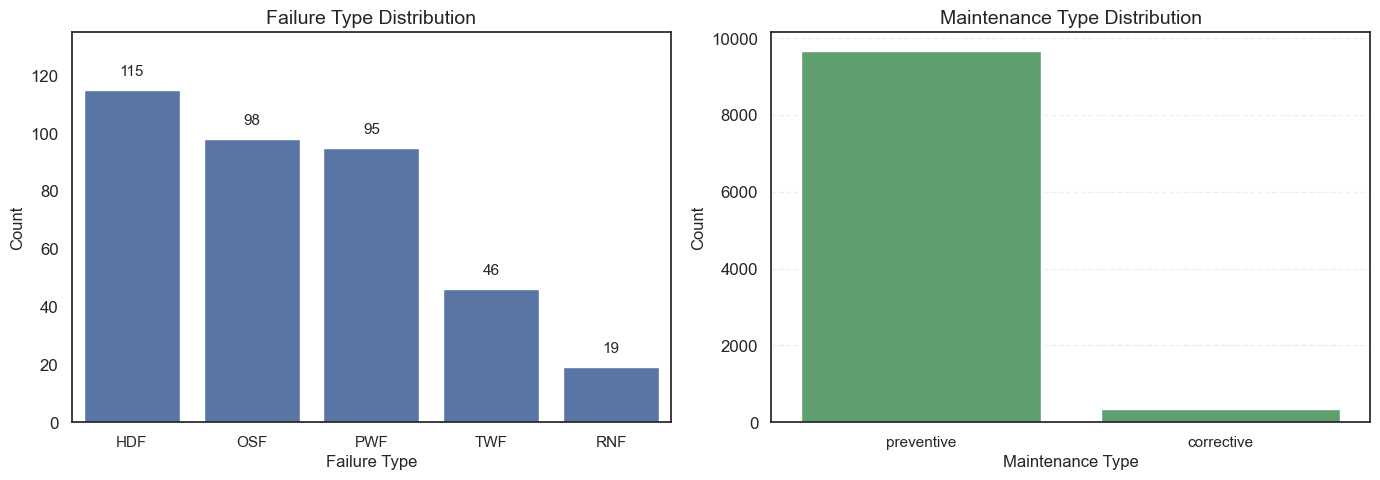

In [275]:
# Colors
failure_color = '#4C72B0'
maintenance_color = '#55A868'

# Data
failure_cols = ['twf', 'hdf', 'pwf', 'osf', 'rnf']
failure_counts = df[failure_cols].sum().sort_values(ascending=False)
maintenance_counts = df['maintenance_type'].value_counts()

# Create side-by-side plots with same size
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Data Visualization 1: (Failure Type Distribution)
sns.barplot(x=failure_counts.index, y=failure_counts.values, color=failure_color, ax=axes[0])
axes[0].set_title('Failure Type Distribution', fontsize=14)
axes[0].set_xlabel('Failure Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels([label.upper() for label in failure_counts.index], fontsize=11)

# Add count labels above each bar
for i, val in enumerate(failure_counts.values):
    axes[0].text(i, val + 5, f'{int(val)}', ha='center', fontsize=11)

# Add space at top
axes[0].set_ylim(0, max(failure_counts.values) + 20)
axes[0].grid(False)




# Data Visualization 2: (Maintenance Type)
sns.barplot(x=maintenance_counts.index, y=maintenance_counts.values, color=maintenance_color, ax=axes[1])
axes[1].set_title('Maintenance Type Distribution', fontsize=14)
axes[1].set_xlabel('Maintenance Type', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xticklabels(maintenance_counts.index, fontsize=11)

# Optional spacing on y-axis to match height visually
axes[1].set_ylim(0, max(maintenance_counts.values) + 500)

# Add grid
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

# Final layout
plt.tight_layout()
plt.show()




### Failure Type Distribution

Displays the frequency of each type of failure which we can use to determine how imbalanced the failure types (multi-label targets) are which is imperative for accurate multi-label classification.

**RNF** is rarest and **HDF** is the most dominant failure

---

### Maintenance Type
Represents the binary classification targets. The graph indicates that the data is heavily weighted towards preventive maintenance and fewer corrective maintenance instances. Therefore, I will need to employ imbalance techniques to prevent the model from default to predicting preventive maintenance every time.


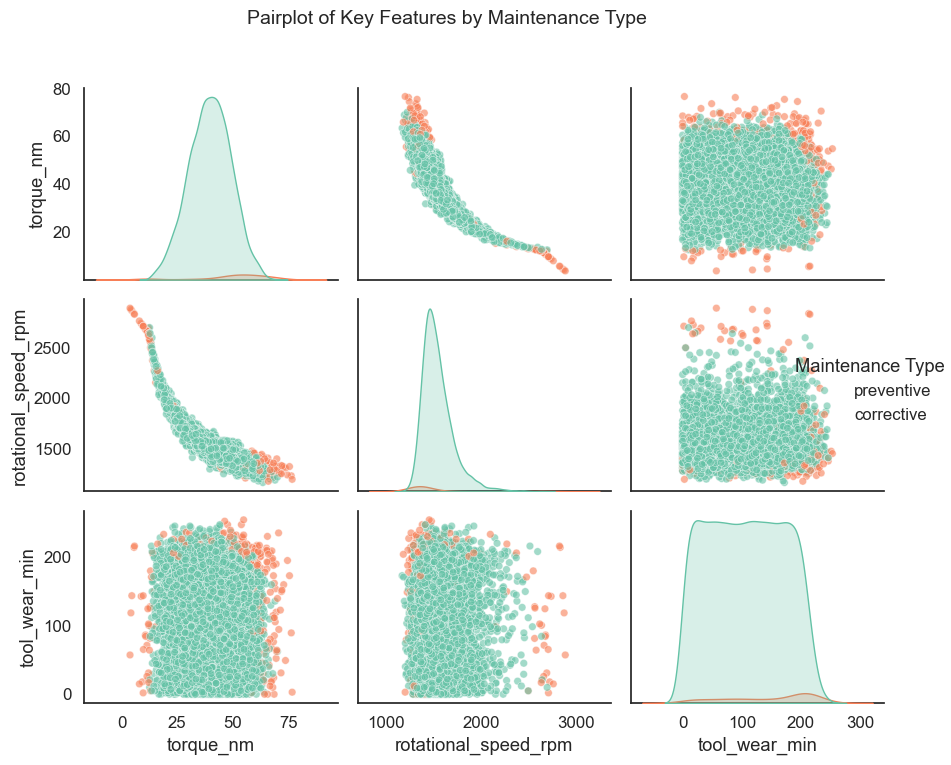

In [276]:
# Data Visualization 3: 

# Key features to visualize
pairplot_features = ['torque_nm', 'rotational_speed_rpm', 'tool_wear_min', 'maintenance_type']

# Custom mint-green & coral-orange palette
custom_palette = {
    'preventive': '#64C2A6',  # mint green
    'corrective': '#F77F57'   # coral orange
}

# Plot
pair = sns.pairplot(
    df[pairplot_features],
    hue='maintenance_type',
    palette=custom_palette,
    plot_kws={'alpha': 0.6, 's': 30},
    diag_kind='kde'  # or 'hist' if you prefer bars
)

pair.fig.subplots_adjust(right=0.85)  # give space for legend
new_legend = pair._legend
new_legend.set_bbox_to_anchor((1.05, 0.5))  # move to right
new_legend.set_title("Maintenance Type")
new_legend.set_frame_on(False)

# Final layout
plt.suptitle('Pairplot of Key Features by Maintenance Type', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


### Layout of the pairplot: 
- Diagonal = KDE (density curves) for each feature.
- Below diagonal = Scatter plots showing how two features relate.
- Colors (green & red) = maintenance_type (preventive vs. corrective).

### Pairplot Analysis: Key Features by Maintenance Type

### Variables Analyzed
- `torque_nm`
- `rotational_speed_rpm`
- `tool_wear_min`
- Colored by `maintenance_type` (preventive vs. corrective)

---

### Key Visual Insights

### 1. `torque_nm` vs `rotational_speed_rpm`
- Strong inverse nonlinear relationship for both maintenance types.
- **Corrective maintenance** clusters at:
  - **High torque + low RPM**
  - **Low torque + high RPM**

**Insight**: Machines operating outside the normal torque–RPM curve are more prone to failure.

---

### 2. `tool_wear_min` vs `rotational_speed_rpm`
- Corrective maintenance is frequent when:
  - **Tool wear > 200 min**
  - **RPM < 1200**

**Insight**: High wear combined with low RPM is a clear failure pattern.

---

### 3. `tool_wear_min` vs `torque_nm`
- Failures occur at **high wear** across all torque levels.
- Some failures also occur at **low torque + high wear**.

**Insight**: Tool wear is the most consistent individual risk factor.

---

### 4. KDE Distributions (Diagonals)
- **Torque**: Corrective cases have wider spread, peak at extremes.
- **RPM**: Corrective = longer right tail, more variability.
- **Tool Wear**: Corrective = right-skewed → more failures at high wear.

**Insight**: Corrective cases are concentrated in **operational extremes**.

---

### Summary of Risk Patterns

| Risk Condition                    | Interpretation                    |
|----------------------------------|------------------------------------|
| Deviations from torque–RPM curve | Operating out of safe zone         |
| Tool wear > 200 + RPM < 1200     | Strong predictor of failure        |
| Tool wear high + torque low      | Indicates mechanical stress/fatigue|
| RPM > 2500 or Torque < 20        | Outliers tied to corrective cases  |

---

### Potential Features & Actions

- `is_high_wear = tool_wear_min > 200`
- `is_low_rpm = rotational_speed_rpm < 1200`
- `torque_rpm_ratio = torque_nm / rotational_speed_rpm`
- `deviation_from_normal_curve` (distance from expected torque–RPM)

Use Cases:
- Predictive maintenance modeling
- Early warning systems
- Power BI risk dashboards





# 




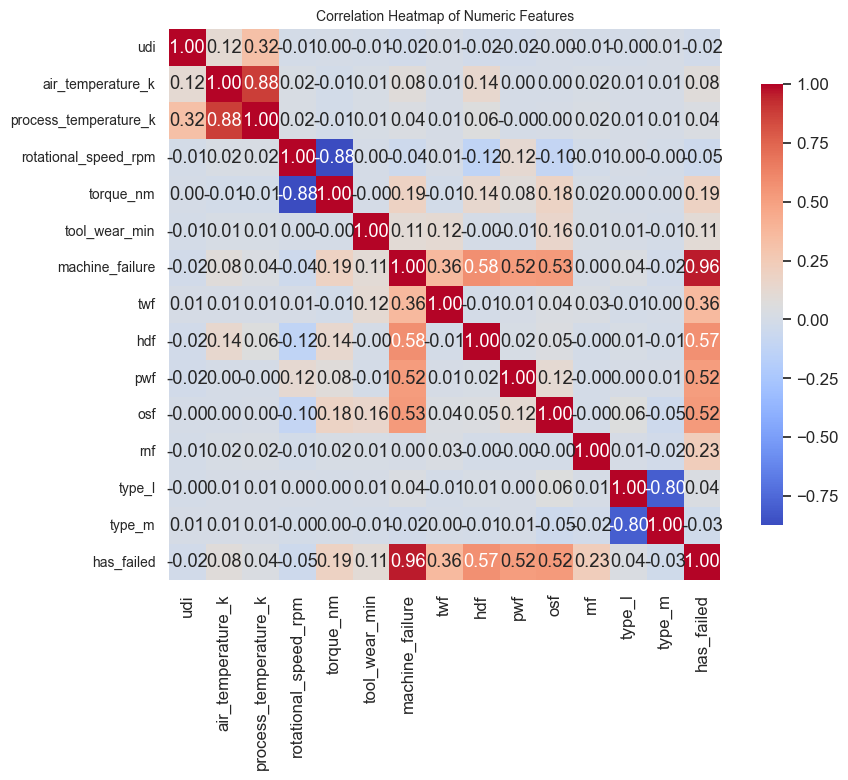

In [277]:
# Data Visualization 4: ()

numeric_cols = df.select_dtypes(include='number')

# calculate correlation matrix
corr_matrix = numeric_cols.corr()

# plot heatmap 
plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'coolwarm', square = True, cbar_kws = {'shrink': 0.8})
plt.title('Correlation Heatmap of Numeric Features', fontsize = 10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()



### Correlation Heatmap of Numeric Features

This heatmap shows the Pearson correlation between numeric features in the dataset.

####  Why It Matters:
- Reveals multicollinearity and feature redundancy.
- Supports smarter feature selection and dimensionality reduction.

#### Key Insights:
- **Torque** and **Rotational Speed** are **strongly negatively correlated** (`-0.88`): higher torque = lower speed.
- **Air Temp** and **Process Temp** are **positively correlated** (`0.88`): likely due to shared heating patterns.
- **Machine Failure** is moderately correlated with individual failure types, confirming it’s a composite indicator.



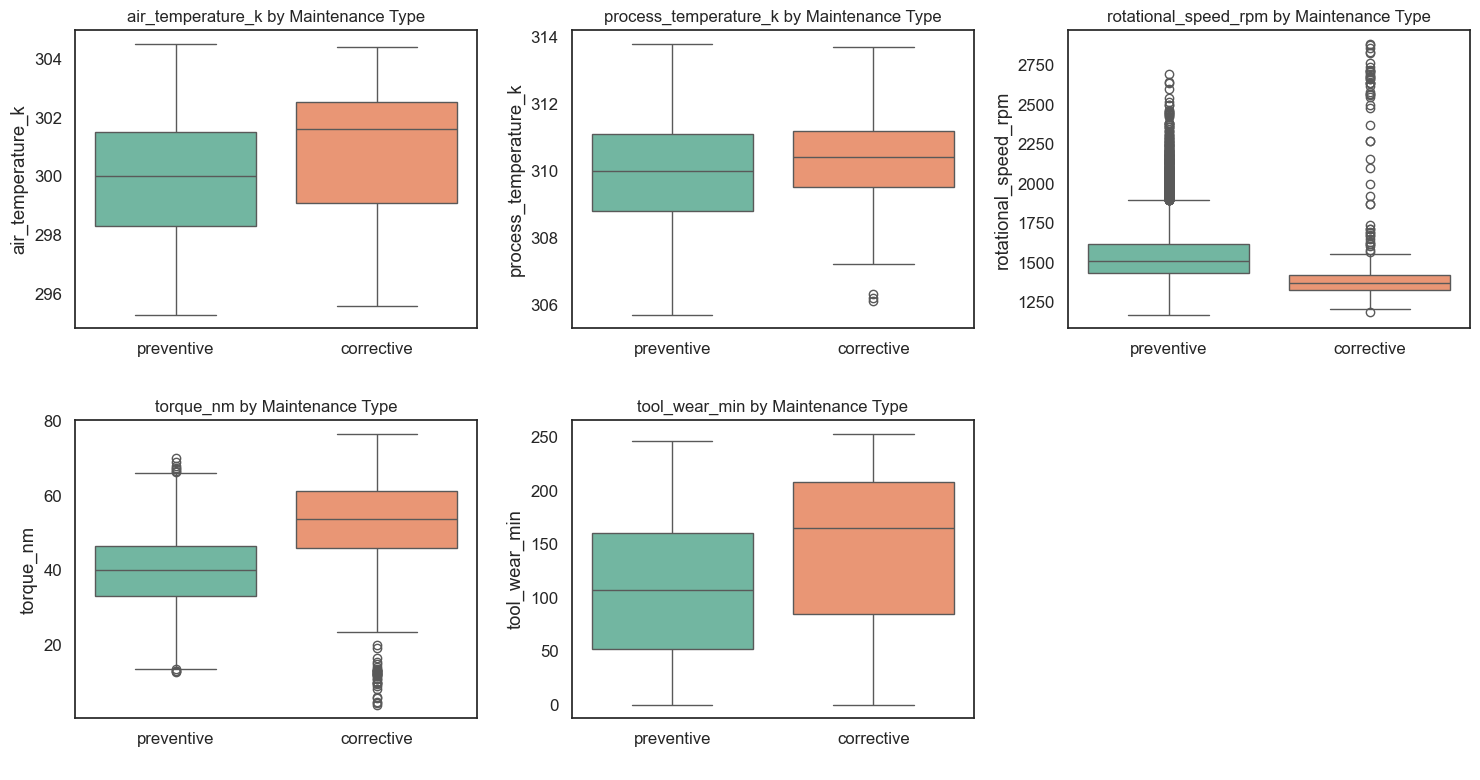

In [278]:
# Data Visualization 5: ()

features_to_plot = ['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']

# Plot

plt.figure(figsize = (15, 8))
for i, col in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data = df, x = 'maintenance_type', y = col, palette = 'Set2')
    plt.title(f'{col} by Maintenance Type', fontsize=12)
    plt.xlabel(' ')
    plt.ylabel(col)

plt.tight_layout()
plt.show()



###  Boxplots of Features by Maintenance Type

These boxplots visualize how key machine features differ between **preventive** and **corrective** maintenance events.

#### Feature-Level Insights:
- **`air_temperature_k`**: Slightly higher for corrective, but overlap is large. Likely **not a strong predictor**.
- **`process_temperature_k`**: Similar story — small shift toward higher values for corrective, but not significant.
- **`rotational_speed_rpm`**: Corrective maintenance tends to occur at **lower RPMs**, while preventive spans higher and more varied speeds.
- **`torque_nm`**: **Clear upward shift** for corrective cases — typically happens at **higher torque levels**. Strong predictive potential.
- **`tool_wear_min`**: Most distinct separation — **corrective maintenance strongly linked to high tool wear**. Excellent feature for classification.

#### Why This Matters:
Boxplots reveal which features **visually separate the two maintenance types**.  
**Tool wear**, **torque**, and **rotational speed** show the clearest differences and are likely to be **key predictors** in any failure prediction model.


# Binary Classification

In [279]:

# Drop Columns
features = ['air_temperature_k', 'process_temperature_k', 'rotational_speed_rpm', 
            'torque_nm', 'tool_wear_min', 'type_l', 'type_m']
X = df[features] 

# Target Variable
y = df['machine_failure']

# Split the dataset into training and testing sets
# ------------------------------------------------
# X: feature matrix (independent variables)
# y: target vector (machine_failure — 0 or 1)

# test_size = 0.2 → allocate 20% of the data to the test set and 80% to training
# stratify=y → ensures that the proportion of classes remains the same in both training and test sets. 
# random_state = 42 → sets a seed for the random number generator to ensure reproducibility.
#                   This guarantees the same split every time the code is run.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 42 
)

# - LogisticRegression:
#     - class_weight='balanced': automatically adjusts weights inversely proportional to class frequencies.
#       This ensures the model gives more importance to the minority class (corrective maintenance/failures),
#       helping combat the effects of class imbalance.
#     - max_iter=1000: increases the maximum number of optimization iterations allowed during training.
#       This prevents convergence issues on complex datasets and ensures the solver has enough time to find
#       the best coefficients.

# - RandomForestClassifier:
#     - class_weight='balanced': similar reasoning as above; ensures minority class is not ignored.
#     - random_state=42: sets a fixed seed for reproducibility. Ensures the model behaves the same
#       each time it's trained, which is helpful for debugging and consistent results.
models = {
    "Logistic Regression": LogisticRegression(class_weight = 'balanced', max_iter = 1000),
    "Random Forest": RandomForestClassifier(class_weight = 'balanced', random_state = 42)
}

# Loop through each model and evaluate performance
for name, model in models.items():

    # 1. Train the model on the training set
    model.fit(X_train, y_train)
    # 2. Predict class labels on the test set
    y_pred = model.predict(X_test)

    # 3. Compute the ROC AUC score
    # - model.predict_proba(X_test)[:, 1] gives the predicted probabilities of the positive class (1 = failure)
    # - roc_auc_score evaluates how well the model ranks true positives over false positives
    # - AUC ranges from 0.5 (random guessing) to 1.0 (perfect separation)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])


    print(f"\n {name} ")
    print(classification_report(y_test, y_pred))
    print(f"AUC Score: {auc:.4f}")


 Logistic Regression 
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1932
           1       0.14      0.82      0.25        68

    accuracy                           0.83      2000
   macro avg       0.57      0.83      0.57      2000
weighted avg       0.96      0.83      0.88      2000

AUC Score: 0.9069

 Random Forest 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1932
           1       0.94      0.47      0.63        68

    accuracy                           0.98      2000
   macro avg       0.96      0.73      0.81      2000
weighted avg       0.98      0.98      0.98      2000

AUC Score: 0.9631


###  Binary Classification Model Comparison

We trained and evaluated two models to predict whether a machine will fail (`machine_failure`: 0 or 1). Below are the results:

---

#### Random Forest Classifier

- **Accuracy**: 98%
- **AUC Score**: 0.9631
- **Precision (Failure Class)**: 0.94
- **Recall (Failure Class)**: 0.47
- **F1-Score (Failure Class)**: 0.63

**Strengths:**
- Excellent overall accuracy and AUC.
- Very few false positives (high precision).
- Perfect recall on non-failure cases (0 = 1.00).

**Weakness:**
- Recall for failure cases (1) is only 0.47 — over half of real failures are missed.

---

#### Logistic Regression

- **Accuracy**: 83%
- **AUC Score**: 0.9069
- **Precision (Failure Class)**: 0.14
- **Recall (Failure Class)**: 0.82
- **F1-Score (Failure Class)**: 0.25

**Strengths:**
- High **recall** for failure cases — catches 82% of actual failures.
- Strong class separation overall (AUC > 0.90).

**Weaknesses:**
- Extremely low precision for failure class (many false positives).
- Predicts too many failures, lowering overall accuracy.

---

### Conclusion

- **Random Forest** is better balanced and more reliable overall — especially for precision-focused use cases.
- **Logistic Regression** is more aggressive at catching failures (higher recall) but produces many false alarms.
- If **missing a failure is more costly**, Logistic Regression (or adjusting thresholds on RF) may be preferable.
- Final choice depends on the use case:
  - Use RF for **precision-critical tasks**
  - Use Logistic Regression or tune thresholds for **recall-critical tasks**

---

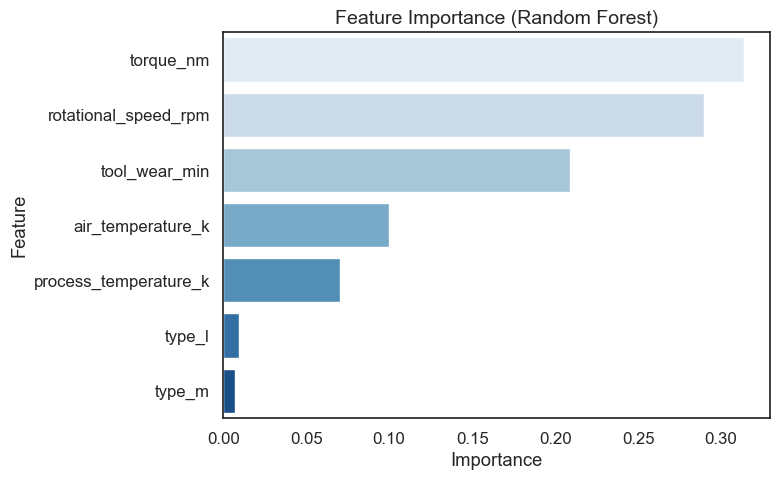

In [280]:
#
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (8, 5))
sns.barplot(x = 'Importance', y = 'Feature', data = importance_df, palette = 'Blues')
plt.title('Feature Importance (Random Forest)', fontsize = 14)
plt.tight_layout()
plt.show()



###  Feature Importance (Random Forest)

The plot above shows the relative importance of input features based on the trained Random Forest model. This helps identify which factors most influence the prediction of machine failure:

- **Torque (`torque_nm`)** is by far the most impactful feature — likely indicating mechanical strain.
- **Rotational Speed (`rotational_speed_rpm`)** and **Tool Wear (`tool_wear_min`)** also strongly contribute to risk of failure.
- **Temperature metrics** have a moderate effect, while **machine type** plays a minor role.

This confirms that **real-time sensor data** is critical for predictive maintenance.


# Multi-Label Classification 

In [281]:


# Target var setup: Multi-label (each column is a binary label)
y_multi = df[['twf', 'hdf', 'pwf', 'osf', 'rnf']]

# Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_multi, test_size = 0.2, random_state = 42
)

# Creates a multi-label classification model using MultiOutputClassifier
# --------------------------------------------------------------------
# - MultiOutputClassifier allows us to predict multiple binary target labels independently.
# - Each target (twf, hdf, pwf, osf, rnf) gets its own separate Random Forest model.
# - RandomForestClassifier is used as the base estimator because it handles non-linear patterns well
#   and supports class_weight balancing

multi_model = MultiOutputClassifier(
    RandomForestClassifier(class_weight = 'balanced', random_state = 42)
)

# Trains the multi-label model using features (X_train), and multi-label targets (y_train)
multi_model.fit(X_train, y_train)

# Predict all 5 failure types (multi-label) on the test set
y_pred_multi = multi_model.predict(X_test)

# Classification report for each predicted failure type
print("Multi-Label Classification Report")
for i, col in enumerate(y_multi.columns):
    print(f"\n {col.upper()}")
    print(classification_report(y_test.iloc[:, i], y_pred_multi[:, i]))


Multi-Label Classification Report

 TWF
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1989
           1       0.00      0.00      0.00        11

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      0.99      0.99      2000


 HDF
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1983
           1       0.91      0.59      0.71        17

    accuracy                           1.00      2000
   macro avg       0.95      0.79      0.86      2000
weighted avg       1.00      1.00      1.00      2000


 PWF
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1980
           1       0.80      0.40      0.53        20

    accuracy                           0.99      2000
   macro avg       0.90      0.70      0.76      2000
weighted avg       0.9

###  Multi-Label Classification Insights

Trained a multi-output Random Forest model to predict five specific failure types simultaneously: `TWF`, `HDF`, `PWF`, `OSF`, and `RNF`.

---

####  Per-Class Performance Summary:

| Failure Type | Precision | Recall | F1-Score | Support | Interpretation |
|--------------|-----------|--------|----------|---------|----------------|
| **TWF**      | 0.00      | 0.00   | 0.00     | 11      | Model failed to detect any tool wear failures — likely due to extreme class imbalance. |
| **HDF**      | 0.91      | 0.59   | 0.71     | 17      | Good performance despite low support — strong precision, decent recall. |
| **PWF**      | 0.80      | 0.40   | 0.53     | 20      | Precision is promising, but the model misses over half of actual power failures. |
| **OSF**      | 0.83      | 0.56   | 0.67     | 18      | Balanced performance — model detects more than half with solid precision. |
| **RNF**      | 0.00      | 0.00   | 0.00     | 6       | Similar to TWF, model fails entirely due to lack of examples. |

---

### Key Insights:

- **Class imbalance is a critical issue.** TWF and RNF failures are severely underrepresented, leading to zero recall and poor performance.
- **Overall accuracy is misleading** (≈ 99%) because most examples are negative cases. Metrics like **recall** and **F1** are more meaningful here.
- **HDF and OSF** are the most successfully predicted labels, with F1-scores above 0.65 — suggesting the model can learn useful patterns even with moderate support.
- The model tends to favor **precision over recall**, meaning it avoids false positives but misses some real failures.

---

# Final Conclusion
---


The project highlighted how machine learning can be used to predict machine failures using operational sensor data from the AI4I 2020 predictive maintenance dataset. We explored both binary classification (predicting whether a machine will fail) and multi-label classification (predicting specific failure types such as TWF, HDF, etc.).

The binary classification model is useful for sending early warning signals to maintenance teams, allowing them to take proactive measures and prevent unplanned downtime. In contrast, the multi-label classification model helps identify the specific type of failure, which enables more targeted repairs, better parts inventory management, and efficient resource allocation.

In real-world industrial settings, these models could be integrated into production monitoring systems or dashboards (e.g., Power BI or SCADA) to enhance decision-making and reduce operational costs. Industries like manufacturing, energy, automotive, and defense can greatly benefit from predictive maintenance strategies powered by these models.

While the models performed well on this synthetic dataset, real-world applications would require testing on actual sensor data, ongoing model retraining, and close integration with industrial operations.

Furthermore, features such as torque, tool wear, and rotational speed are the most predictive of machine failure. Based on this, teams should monitor these in real time and flag machines with extreme torque-wear combos

Future work could involve exploring more advanced models (e.g., XGBoost, deep learning), incorporating temporal features, and building real-time predictive pipelines for deployment in smart factories or defense logistics environments.

---

### Power BI Dashboard


While the machine learning model provides predictions, this project integrates with a Power BI dashboard for executive-level decision-making and transforms those predictions into actionable intelligence. By visualizing failure risk, top predictive features, and machine-level insights, this dashboard empowers teams to make faster, data-informed decisions.

Two CSVs were exported:
- `predictive_maintenance_output.csv`: real-time predictions, probabilities, and recommended actions
- `feature_importance.csv`: top features driving model decisions

The dashboard enables maintenance planners to:
- Visualize high-risk machines in real time
- Understand key drivers of equipment failure
- Prioritize inspections based on data-driven predictions


In [282]:
# Combine multi-label model output + features

# Reset indexes to avoid merge issues
powerbi_df = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# For MultiOutputClassifier: this gives a list of arrays (1 per target)
# But if you're using a binary classifier model, this works as-is:
powerbi_df['failure_probability'] = model.predict_proba(X_test)[:, 1]  # Only valid for binary or single output
powerbi_df['predicted_failure'] = model.predict(X_test)

# Add high-risk logic and maintenance recommendation
powerbi_df['is_high_risk'] = (powerbi_df['failure_probability'] > 0.7).astype(int)
powerbi_df['recommended_action'] = powerbi_df['is_high_risk'].map({
    1: 'Immediate inspection',
    0: 'Monitor'
})

# Export to CSV for Power BI
powerbi_df.to_csv("predictive_maintenance_output.csv", index = False)


# feature importance export (Random Forest)
importances = model.feature_importances_
features = X_train.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by = 'Importance', ascending = False)

importance_df.to_csv("feature_importance.csv", index = False)
